# Speech-to-Text (STT) Notebook
A structured workflow for development and experimentation.

## Environment Setup (pip installs, conda setup, dependencies)

In [1]:
# !pip install https://github.com/huggingface/transformers/archive/main.zip torchaudio peft soundfile
# !pip install https://files.pythonhosted.org/packages/fc/ca/83398cfcd557360a3d7b2d732aee1c5f6999f68618d1645f38d53e14c9ff/vosk-0.3.45-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
# !pip -q install vosk pydub psutil jiwer
# !pip -q install faster-whisper soundfile
# !pip -q install transformers soundfile librosa jiwer psutil


## Imports (all Python imports in one place)

In [2]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration, AutoProcessor, AutoModelForSpeechSeq2Seq
from datasets import load_dataset

import vosk

import torchaudio
from huggingface_hub import hf_hub_download

## Configuration

## Data / Inputs

# **Models**

## Facebook s2t-small-librispeech-asr

### Model Setup

In [3]:
import transformers, torch
print("Transformers:", transformers.__version__, "| Torch CUDA:", torch.cuda.is_available())


Transformers: 4.56.0.dev0 | Torch CUDA: False


In [4]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

MODEL_ID = "facebook/s2t-small-librispeech-asr"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = Speech2TextProcessor.from_pretrained(MODEL_ID)
model = Speech2TextForConditionalGeneration.from_pretrained(MODEL_ID)
model.to(DEVICE)  # keep float32; this model is stable in fp32

print("Loaded:", MODEL_ID, "| Device:", DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded: facebook/s2t-small-librispeech-asr | Device: cpu


### Compute Model

In [5]:
import time, psutil, numpy as np, soundfile as sf, librosa, torch

AUDIO_PATH = "/content/ref.wav"

# Load audio as mono 16 kHz float32
# (librosa handles resampling; S2T uses 16k log-mels)
wave, sr = librosa.load(AUDIO_PATH, sr=16_000, mono=True)
audio_dur_sec = len(wave) / 16_000.0

# Features
inputs = processor(wave, sampling_rate=16_000, return_tensors="pt")
input_features = inputs.input_features.to(DEVICE)
attn_mask = inputs.attention_mask.to(DEVICE) if "attention_mask" in inputs else None

# Decode
t0 = time.time()
with torch.inference_mode():
    generated_ids = model.generate(
        input_features,
        attention_mask=attn_mask,
        max_length=448,     # safe cap; adjust if your files are long
        num_beams=1,        # greedy for speed
        do_sample=False
    )
wall = time.time() - t0

# Text
s2t_transcript = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

# Metrics
rtf = wall / max(audio_dur_sec, 1e-6)
proc = psutil.Process()
mem_mb = proc.memory_info().rss / (1024**2)
cpu_pct = psutil.cpu_percent(interval=0.2)

print("— TRANSCRIPT —")
print(s2t_transcript if s2t_transcript else "(empty)")
print("\n— STATS —")
print(f"duration_sec: {audio_dur_sec:.4f}")
print(f"wall_time_sec: {wall:.4f}")
print(f"real_time_factor: {rtf:.4f}")
print(f"cpu_percent: {cpu_pct:.2f}")
print(f"mem_rss_mb: {mem_mb:.2f}")


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


— TRANSCRIPT —
let your descending currents are any to make sure you are climbing not the center of the gunwale to teach you to go say altitude but the following principle the futubo of the two are climb immediately climb the aeroplane maintain five thousand climbing up lamp leaves just level up the plane and climb the upside the five thousand when you can certainly begin to begin against it how you who so i shall have the fire a fire a fire is a fire of the first and a fire is a fire of the fire is a fire for the first and a fire and a fire of the fire of the fire and a fire is the fire and a fire and a fire and a fire and a feather so the fire and a fire and the fire and the fire and a fire and the fire is the fire is the fire is the fire so the fire and the fire and the fire and the fire and the fire and the fire and the fire is the fire is the fire is the fire is the fire is the fire and the fire and the fire and the fire and the fire and the fire and the fire and the fire and the 

In [6]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration, pipeline

AUDIO_PATH = "/content/ref.wav"
MODEL_ID   = "facebook/s2t-small-librispeech-asr"

processor = Speech2TextProcessor.from_pretrained(MODEL_ID)
model = Speech2TextForConditionalGeneration.from_pretrained(MODEL_ID)
asr_s2t = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    device=0 if torch.cuda.is_available() else -1,
)

s2t_out = asr_s2t(
    AUDIO_PATH,
    chunk_length_s=15, stride_length_s=(2,2),
    generate_kwargs=dict(
        num_beams=3,
        no_repeat_ngram_size=3,
        repetition_penalty=1.2,
        length_penalty=1.0,
        max_new_tokens=200,
        early_stopping=True,
    ),
)
s2t_transcript = s2t_out["text"]
print("S2T:", s2t_transcript[:200], "…")


Device set to use cpu
Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily be entirely accurate and will have caveats. More information: https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(..., ignore_warning=True).


S2T: let your defending tyranny to make sure you are climbing not the hunting of the gunwales to teach you to say altitude but but without agrivot continued aglow a particular climb immediately climb the a …


## Vosk

### Model Setup

In [7]:
import os, zipfile, urllib.request

model_url = "https://alphacephei.com/vosk/models/vosk-model-small-en-us-0.15.zip"
zip_path  = "/content/vosk-model-small-en-us-0.15.zip"
model_dir = "/content/vosk-model-small-en-us-0.15"

if not os.path.exists(model_dir):
    print("Downloading Vosk small EN model...")
    urllib.request.urlretrieve(model_url, zip_path)
    print("Unzipping...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall("/content")
    os.remove(zip_path)
else:
    print("Model already present")

print("Model ready:", model_dir, "| Exists:", os.path.isdir(model_dir))


Model already present
Model ready: /content/vosk-model-small-en-us-0.15 | Exists: True


### Computer Model

In [8]:
import json, time, subprocess, tempfile, psutil
from pathlib import Path
from pydub import AudioSegment
from vosk import Model, KaldiRecognizer

AUDIO_PATH = Path("/content/ref.wav")
MODEL_DIR  = Path("/content/vosk-model-small-en-us-0.15")

def ensure_pcm16_mono_16k(in_path: Path) -> Path:
    out_wav = Path(tempfile.gettempdir()) / f"conv_{in_path.stem}_16k_mono.wav"
    cmd = [
        "ffmpeg","-y",
        "-i", str(in_path),
        "-ac","1","-ar","16000","-f","wav","-acodec","pcm_s16le",
        str(out_wav)
    ]
    # Colab has ffmpeg preinstalled
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)
    return out_wav

def transcribe_file_vosk(model_dir: Path, audio_path: Path):
    t0 = time.time()
    model = Model(str(model_dir))
    rec = KaldiRecognizer(model, 16000)
    rec.SetWords(True)

    wav_path = ensure_pcm16_mono_16k(audio_path)
    pcm = AudioSegment.from_wav(wav_path)
    raw = pcm.raw_data

    # ~30 ms chunking
    chunk_ms = 30
    step = int(16000 * 2 * chunk_ms / 1000)  # bytes per 30 ms (16k * 2 bytes)
    for i in range(0, len(raw), step):
        rec.AcceptWaveform(raw[i:i+step])

    final_json = json.loads(rec.FinalResult())
    text = final_json.get("text", "")

    wall = time.time() - t0
    dur  = len(pcm) / 1000.0
    rtf  = wall / max(dur, 1e-6)

    proc = psutil.Process()
    mem_mb = proc.memory_info().rss / (1024**2)
    cpu_pct = psutil.cpu_percent(interval=0.2)

    stats = dict(duration_sec=dur, wall_time_sec=wall, real_time_factor=rtf,
                 cpu_percent=cpu_pct, mem_rss_mb=mem_mb)
    return text, stats

vosk_text, stats = transcribe_file_vosk(MODEL_DIR, AUDIO_PATH)

print("— TRANSCRIPT —")
print(vosk_text if vosk_text else "(empty)")
print("\n— STATS —")
for k, v in stats.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")


— TRANSCRIPT —
they would like you're defending their any to make sure you are climbing not been able to to roughly altitude a quarter of a critical to go blow up a similar crime immediately climb the airplane maintained by about and cry me a point where you level up a plane and climb the airplane up to five thousand when you cancer and you appear to be defended against the call you out the gate area for about a half hour by hour

— STATS —
duration_sec: 26.5020
wall_time_sec: 22.7523
real_time_factor: 0.8585
cpu_percent: 67.5000
mem_rss_mb: 1902.2891


## Facebook - Wav2Vec2-Base-960h

### Model Setup

In [9]:
import torch, psutil
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, pipeline

MODEL_ID = "facebook/wav2vec2-base-960h"
AUDIO_PATH = "/content/ref.wav"

device = "cuda" if torch.cuda.is_available() else "cpu"
device_index = 0 if device == "cuda" else -1

# Load processor + model
processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

# Optional: dynamic quantization on CPU to reduce RAM (safe to skip on GPU)
if device == "cpu":
    model = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )

model.to(device).eval()

# Build a pipeline so we get robust long-audio chunking
asr = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    device=device_index,
)
print(f"Ready on {device} (quantized={device=='cpu'})")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3987570563.py:16: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model = torc

Ready on cpu (quantized=True)


### Model Compute

In [10]:
import time, soundfile as sf, psutil

# Audio duration for RTF
info = sf.info(AUDIO_PATH)
audio_dur_sec = info.frames / max(info.samplerate, 1)

t0 = time.time()
out = asr(
    AUDIO_PATH,
    chunk_length_s=20,        # chunking keeps RAM flat
    stride_length_s=(2, 2),   # small overlap
    return_timestamps="word", # <-- FIX for CTC pipelines
    # ignore_warning=True,    # optional
)
wall = time.time() - t0
rtf = wall / max(audio_dur_sec, 1e-6)

proc = psutil.Process()
mem_mb = proc.memory_info().rss / (1024**2)
cpu_pct = psutil.cpu_percent(interval=0.2)

wav2vec2_text = out["text"].strip() if isinstance(out, dict) else str(out).strip()

print("— TRANSCRIPT —")
print(wav2vec2_text if wav2vec2_text else "(empty)")

print("\n— STATS —")
print(f"duration_sec: {audio_dur_sec:.4f}")
print(f"wall_time_sec: {wall:.4f}")
print(f"real_time_factor: {rtf:.4f}")
print(f"cpu_percent: {cpu_pct:.2f}")
print(f"mem_rss_mb: {mem_mb:.2f}")


— TRANSCRIPT —
IT WOS LIKE YOUR DEFENDING SERANY TO MAKE SURE YOU ARE CLIMBING NOT DEFFENDING OTE PILOT ERTUCHUGOV THE ALPITUDE A CE FOO IT TO THE GTEIRTUCHYUGOV LOW OUP TATULAR CLIME IMMEDIATELY CLIMB THE ARPLANE MAINTAIN FIVE THOUSAND CLIMBTHE AIRPLAME WIT JUST LEVER OU THE PLANE AND CLIMB THE AIR PLING UP THE FIVE THOUSAND WHENE HY CANCER AN YOU APPEAR TO BE THE SENDING AGAINST SIR CARU WHO SO OFPITUDE I TARA E CAKACASTA ABOUT A HALF HILE A FARLER HENTED OUT

— STATS —
duration_sec: 26.5018
wall_time_sec: 18.7231
real_time_factor: 0.7065
cpu_percent: 67.50
mem_rss_mb: 2730.44


## OpenAI - Whisper

### Model Setup

In [11]:
import torch, psutil, time, soundfile as sf
from faster_whisper import WhisperModel

AUDIO_PATH = "/content/ref.wav"

# Choose size: "tiny", "base", ("small", "medium" also exist but heavier)
MODEL_SIZE = "base"

# Auto-select device/precision
if torch.cuda.is_available():
    DEVICE = "cuda"
    COMPUTE_TYPE = "float16"   # good default for GPU
else:
    DEVICE = "cpu"
    COMPUTE_TYPE = "int8"      # efficient on CPU

print(f"Using model={MODEL_SIZE}, device={DEVICE}, compute_type={COMPUTE_TYPE}")
model = WhisperModel(MODEL_SIZE, device=DEVICE, compute_type=COMPUTE_TYPE)


Using model=base, device=cpu, compute_type=int8


### Compute Model

In [12]:
import itertools

# Load once to get duration for RTF
info = sf.info(AUDIO_PATH)
audio_dur_sec = info.frames / max(info.samplerate, 1)

t0 = time.time()
segments, info_rt = model.transcribe(
    AUDIO_PATH,
    language="en",           # English only (skips auto-detect)
    task="transcribe",       # not "translate"
    beam_size=1,             # greedy for speed; set >1 for accuracy
    vad_filter=True,         # basic VAD can help on noisy files
)
# Collect text (order preserved)
whisper_text = " ".join(s.text.strip() for s in segments)

wall = time.time() - t0
rtf = wall / max(audio_dur_sec, 1e-6)

proc = psutil.Process()
mem_mb = proc.memory_info().rss / (1024**2)
cpu_pct = psutil.cpu_percent(interval=0.2)

print("— TRANSCRIPT —")
print(whisper_text if whisper_text else "(empty)")
print("\n— STATS —")
print(f"duration_sec: {audio_dur_sec:.4f}")
print(f"wall_time_sec: {wall:.4f}")
print(f"real_time_factor: {rtf:.4f}")
print(f"cpu_percent: {cpu_pct:.2f}")
print(f"mem_rss_mb: {mem_mb:.2f}")

# Extra info from faster-whisper (when available)
if info_rt is not None:
    # info_rt might have attributes like duration, transcription options, etc.
    try:
        print("\n— RUNTIME INFO —")
        print(f"language: {info_rt.language}")
        print(f"language_probability: {info_rt.language_probability:.4f}")
        print(f"duration (reported): {info_rt.duration:.4f}")
    except Exception:
        pass


— TRANSCRIPT —
It looks like you're descending, sir. I need to make sure you are climbing not descending. Go to the pilot. There are two two golf say altitude. Go to the pilot. Go to the golf. There are two two golf low altitude alert. Climb immediately. Climb the airplane. Maintain 5,000. Climb the airplane, please. Just level up the plane and climb the airplane up to 5,000 when you can, sir. You appear to be descending again, sir. Are you, sir, altitude? I tell you, I have to discuss about a half mile of further into the helicopter.

— STATS —
duration_sec: 26.5018
wall_time_sec: 12.1745
real_time_factor: 0.4594
cpu_percent: 7.50
mem_rss_mb: 2986.26

— RUNTIME INFO —
language: en
language_probability: 1.0000
duration (reported): 26.5018


## Model Comparison

In [13]:
ref_str = "It looks like your descending, sir I need to make sure you are climbing not descending, Gold is climbing 22G, say altitude 2500, 22G, 22G low altitude alert, climb the airplane maintain 5000, climb the airplane please, just level off the plane and climb the airplane up to 5000, when you can, sir, you appear to be descending again sir, Are you... say altitude. Tower the aircraft has crashed uhh... about half a mile in front of us into the houses"

,backend,wer_raw,acc_raw,wer_norm,acc_norm,correctness,precision,f1,ref_words,hyp_words,S,D,I,C,hyp_preview
0,whisper,0.5556,0.4444,0.3736,0.6264,0.7253,0.6600,0.6911,91,100,25,0,9,66,"It looks like you're descending, sir. I need t..."
1,vosk,0.7654,0.2346,0.6703,0.3297,0.3516,0.3855,0.3678,91,83,49,10,2,32,they would like you're defending their any to ...
2,wav2vec2,0.7531,0.2469,0.6813,0.3187,0.3297,0.3659,0.3468,91,82,51,10,1,30,IT WOS LIKE YOUR DEFENDING SERANY TO MAKE SURE...
3,s2t-small,0.9753,0.0247,0.8571,0.1429,0.4286,0.3545,0.3881,91,110,45,7,26,39,let your defending tyranny to make sure you ar...


Saved → /content/asr_eval_summary.csv


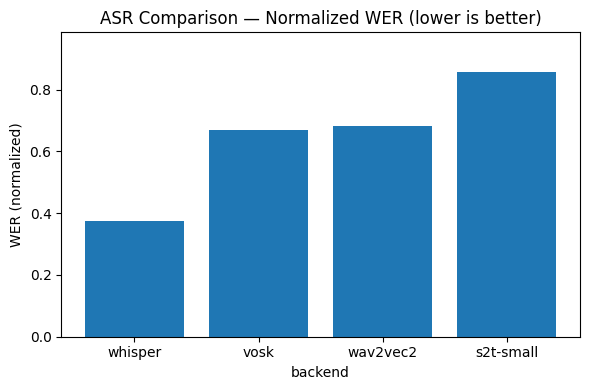

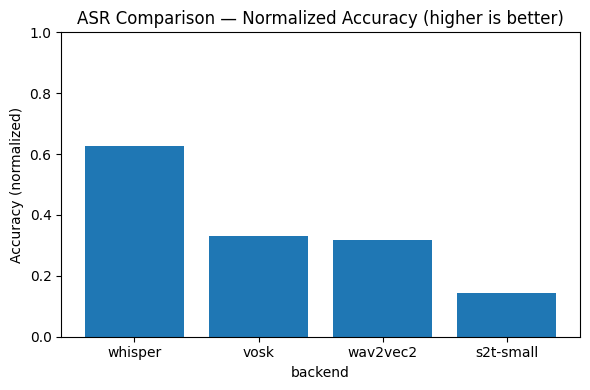

Best by acc_norm: whisper (62.64%)


In [16]:
# %% ASR 4-way comparison with Accuracy + Correctness/Precision/F1
# Expects these variables to be defined earlier:
#   ref_str, vosk_text, whisper_text, wav2vec2_text, s2t_transcript
# Optional installs (uncomment if needed):
# !pip -q install pandas matplotlib

import re, os, csv
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Normalization tuned for ATC-ish speech ----------
def normalize_atc(s: str) -> str:
    if s is None:
        return ""
    s = s.lower()
    # map common domain tokens
    s = s.replace("22g", "two two golf")
    s = s.replace("5,000", "five thousand").replace("5000", "five thousand")
    s = s.replace("2500", "two thousand five hundred")
    s = s.replace("gold", "golf")
    # drop fillers, punctuation, collapse spaces
    s = re.sub(r"\b(uh+|um+)\b", " ", s)
    s = re.sub(r"[‐–—…]", " ", s)          # normalize dashes/ellipses
    s = re.sub(r"[^\w\s]", " ", s)         # strip punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_raw(s: str) -> str:
    if s is None:
        return ""
    s = s.lower()
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# ---------- Levenshtein alignment to get S/D/I + matches ----------
def align_counts(ref_tokens, hyp_tokens):
    R, H = ref_tokens, hyp_tokens
    n, m = len(R), len(H)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(1, n+1): dp[i][0] = i
    for j in range(1, m+1): dp[0][j] = j
    for i in range(1, n+1):
        for j in range(1, m+1):
            if R[i-1] == H[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = min(dp[i-1][j] + 1,    # deletion
                               dp[i][j-1] + 1,    # insertion
                               dp[i-1][j-1] + 1)  # substitution
    # backtrack to count
    i, j = n, m
    S = D = I = C = 0
    while i > 0 or j > 0:
        if i>0 and j>0 and R[i-1] == H[j-1] and dp[i][j] == dp[i-1][j-1]:
            C += 1; i -= 1; j -= 1
        elif i>0 and j>0 and dp[i][j] == dp[i-1][j-1] + 1:
            S += 1; i -= 1; j -= 1
        elif i>0 and dp[i][j] == dp[i-1][j] + 1:
            D += 1; i -= 1
        else:
            I += 1; j -= 1
    return {"S": S, "D": D, "I": I, "C": C, "N": n, "M": m}

def metrics_from_tokens(ref_toks, hyp_toks):
    c = align_counts(ref_toks, hyp_toks)
    N, M = max(1, c["N"]), max(1, c["M"])
    S, D, I, C = c["S"], c["D"], c["I"], c["C"]
    wer = (S + D + I) / N
    acc = max(0.0, 1.0 - wer)
    # correctness = recall of reference words; precision = cleanliness of hypothesis
    correctness = C / N
    precision   = C / M
    f1 = 0.0 if (correctness + precision) == 0 else 2 * correctness * precision / (correctness + precision)
    return {
        "wer": wer, "acc": acc,
        "correctness": correctness,
        "precision": precision,
        "f1": f1,
        "ref_words": c["N"], "hyp_words": c["M"],
        "S": S, "D": D, "I": I, "C": C
    }

def score_pair(name, hyp_raw, ref_raw):
    # RAW tokens
    ref_r = normalize_raw(ref_raw).split()
    hyp_r = normalize_raw(hyp_raw).split()
    raw = metrics_from_tokens(ref_r, hyp_r)
    # DOMAIN-NORMALIZED tokens
    ref_n = normalize_atc(ref_raw).split()
    hyp_n = normalize_atc(hyp_raw).split()
    norm = metrics_from_tokens(ref_n, hyp_n)

    return {
        "backend": name,
        "wer_raw": round(raw["wer"], 4),
        "acc_raw": round(raw["acc"], 4),
        "wer_norm": round(norm["wer"], 4),
        "acc_norm": round(norm["acc"], 4),
        "correctness": round(norm["correctness"], 4),
        "precision": round(norm["precision"], 4),
        "f1": round(norm["f1"], 4),
        "ref_words": norm["ref_words"],
        "hyp_words": norm["hyp_words"],
        "S": norm["S"], "D": norm["D"], "I": norm["I"], "C": norm["C"],
        "hyp_preview": (str(hyp_raw)[:120] + "…") if hyp_raw and len(str(hyp_raw)) > 120 else str(hyp_raw or "")
    }

# Collect available hypotheses
def _get(name):
    return globals()[name] if name in globals() else None

if "ref_str" not in globals():
    raise RuntimeError("Please define `ref_str` (ground-truth transcript) first.")

pairs = [
    ("whisper",   _get("whisper_text")),
    ("wav2vec2",  _get("wav2vec2_text")),
    ("vosk",      _get("vosk_text")),
    ("s2t-small", _get("s2t_transcript")),
]

rows = [score_pair(name, hyp, ref_str) for name, hyp in pairs if hyp is not None]
df = pd.DataFrame(rows).sort_values(["wer_norm", "backend"]).reset_index(drop=True)
display(df)

# Save CSV (same path as before to keep your workflow)
csv_path = "/content/asr_eval_summary.csv"
df.to_csv(csv_path, index=False)
print(f"Saved → {csv_path}")

# Charts: WER and Accuracy (normalized)
plt.figure(figsize=(6,4))
plt.bar(df["backend"], df["wer_norm"])
plt.title("ASR Comparison — Normalized WER (lower is better)")
plt.xlabel("backend"); plt.ylabel("WER (normalized)")
plt.ylim(0, max(0.05, df["wer_norm"].max()*1.15))
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.bar(df["backend"], df["acc_norm"])
plt.title("ASR Comparison — Normalized Accuracy (higher is better)")
plt.xlabel("backend"); plt.ylabel("Accuracy (normalized)")
plt.ylim(0, 1.0)
plt.tight_layout(); plt.show()

# Optional: print best by acc_norm
if not df.empty:
    best = df.sort_values("acc_norm", ascending=False).iloc[0]
    print(f"Best by acc_norm: {best['backend']} ({best['acc_norm']*100:.2f}%)")
